# A tutorial in torchAttacks (Adversarial attacks)
Here I have followed the following [example](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118) for a convolution neural network.

However I followed this [tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) for the adversarial attack stuff.

## Import.STONKS()

And also defining where to put the model weights

In [1]:
import torch
import torch.nn.functional as F
from torchattacks import *
from torchvision import transforms, models 
import numpy as np
import matplotlib.pyplot as plt
import requests
import cv2
import glob
from torch.autograd import Variable
from captum.attr import IntegratedGradients
from torchattacks.attack import Attack
from torchattack_noClamp import *


train_again = False

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {DEVICE} device")

# Path to saving the attack
if train_again:
    atk_path = "/zhome/06/a/147115/BSc_venv/BachelorProject_XAI/plottables/AttackImnet/AttacksVGGImnet"
else:
    atk_path = "/Users/Alex/Documents/results/plotables/AttackImnet/"
print(f"Saving model in path: {atk_path}")

# Path to data folder
imagePath = "Imagenet_pics"


Using cpu device
Saving model in path: /Users/Alex/Documents/results/plotables/AttackImnet/


## Downloading data

Downloading photo folder. First the processing functions. Pre- and deprocessing of the image

In [2]:

def preprocess(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[None]),
    ])
    return transform(image)

def deprocess(image):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        transforms.ToPILImage(),
    ])
    return transform(image)

# Load and process images
images_cv = [cv2.imread(file) for file in glob.glob('Imagenet_pics/*.JPEG')]
images = [cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB) for im_cv in images_cv]
imgs_var = [Variable(preprocess(im), requires_grad=True).to(DEVICE) for im in images]

# defining labels for imagenet
labels_link = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"    
labels = requests.get(labels_link).json()




## Model under attack

The model obviously also needs to be defined:

In [3]:
#Using VGG-19 pretrained model for image classification
model = models.vgg19(pretrained=True).to(DEVICE)
#for param in model.parameters():
#    param.requires_grad = False

model.eval()
print()

Plot each image and their predictions

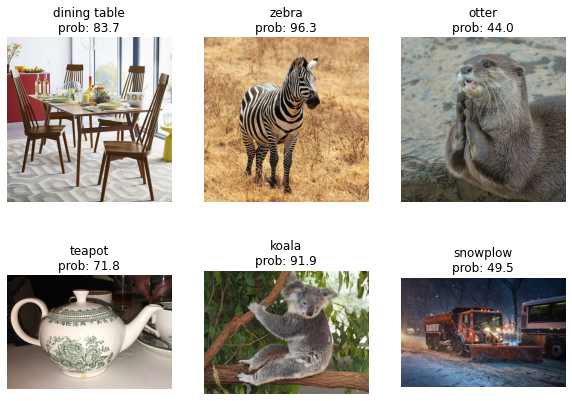

In [4]:

cnt = 1
label_idx = []

plt.figure(figsize=(10,15))


for i in range(len(images)):
        
    output = model(imgs_var[i])
    idx = torch.argmax(output).unsqueeze(0) #torch.max(output.data, 1)   #get an index(class number) of a largest element
    label_idx.append(idx)

    x_pred = labels[idx.item()]
        

    # Probability 
    output_probs = F.softmax(output, dim=1)
    x_pred_prob =  output_probs.max()*100

    plt.subplot(len(imgs_var)//3+2,3,cnt)
    plt.axis('off')
    plt.title(f"{x_pred}\nprob: {x_pred_prob:.1f}")
    plt.imshow(images[i])

    cnt +=1





# Different attacks on the model

In [5]:
atks = [
    VANILA(model),
    FGSM(model, eps=8/255),
    BIM(model, eps=8/255, alpha=2/255, steps=100),
    RFGSM(model, eps=8/255, alpha=2/255, steps=100),
    CW(model, c=1, lr=0.01, steps=100, kappa=0),
    PGD(model, eps=8/255, alpha=2/225, steps=100, random_start=True),
    PGDL2(model, eps=1, alpha=0.2, steps=100),
    EOTPGD(model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    FFGSM(model, eps=8/255, alpha=10/255),
    TPGD(model, eps=8/255, alpha=2/255, steps=100),
    MIFGSM(model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
    GN(model, std=0.1),
    APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='ce'),
    APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='dlr'),
    APGDT(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1),
    FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
    FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    Square(model, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
    AutoAttack(model, eps=8/255, n_classes=10, version='standard'),
    OnePixel(model, pixels=5, inf_batch=50),
    DeepFool(model, steps=100),
    DIFGSM(model, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
]

atks_noClamp = [
    VANILA(model),
    FGSM_noClamp(model, eps=8/255),
    BIM_noClamp(model, eps=8/255, alpha=2/255, steps=100),
    CW_noClamp(model, c=1, lr=0.01, steps=100, kappa=0),
    PGDL2_noClamp(model, eps=1, alpha=0.2, steps=100),
    DeepFool_noClamp(model, steps=100),
    
]


def saliencyMapSingleImage(model, data, label):
    
    # Zero all existing gradient
    model.zero_grad()
    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad_()
    data.retain_grad()
    
    # Get the index corresponding to the maximum score and the maximum score itself.
    scores = model(data)
    
    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max = scores[0,label]
   
    # Compute gradient of score_max with respect to the model
    score_max.backward()
    
    # flatten to one channel
    saliency_mean_abs = torch.mean(data.grad.abs(), dim=1) #torch.max(X.grad.data.abs(),dim=1)
    saliency_max_abs, _ = torch.max(data.grad.abs(), dim=1)

    return saliency_max_abs#, saliency_mean_abs



def intergratedGradSingleImage(model,data,label, trans: bool = False):
    ig = IntegratedGradients(model)
    model.zero_grad()
    attr_ig, delta = ig.attribute(data, target=label.to(DEVICE),baselines=data * 0, return_convergence_delta=True)

    attr_ig, _ = torch.max(attr_ig[0], dim=0,  keepdim=True) # 1 channel
    if trans:
        attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
    
    return attr_ig
 

def advAtkSingleImage(image,label, atk):
    # Attack and Saliency maps
    print("\tAdversarial example")
    adv_image = atk(image, label)
    print("\tSaliency map")
    saliency_grad = saliencyMapSingleImage(model, image, label)
    print("\tIntergrated gradient")
    saliency_intgrad = intergratedGradSingleImage(model, image, label)
    
    # Label and Probability 
    output_adv = model(adv_image)
    label_idx_adv = torch.argmax(output_adv).unsqueeze(0)
    x_pred_prob_adv = F.softmax(output_adv, dim=1).max()*100

    # Determind noise: avd = img + noise => noise = avd - img
    noise = adv_image - image
    noise, _ = torch.max(noise[0], dim=0,  keepdim=True) # 1 channel
    
    # Save info in lists
    adv_dir =  [adv_image, noise, saliency_grad, saliency_intgrad] #['a','b']#[adv_image, noise]
    pred_dir = [label_idx_adv,x_pred_prob_adv] #{"label":label_idx_adv,"prob": x_pred_prob_adv}
    
    return adv_dir, pred_dir





Begin attacking!

In [6]:
if train_again:

    atk_testidx = [0,4,6,20,1,2]
    
    for idx, im in enumerate(imgs_var):
        print("_"*70 +" Image "+str(idx+1))
        # Initialization
        adv_images = []
        pred_images = []
        adv_name = []
        for atk in atks_noClamp:
            print("_"*35)
            print(atk.__class__.__name__)

            # Perform attack on image
            adv_im, adv_pred = advAtkSingleImage(im, label_idx[idx], atk)

            adv_images.append(adv_im)
            pred_images.append(adv_pred)
            adv_name.append(atk.__class__.__name__)
        

        torch.save({"adv_name": adv_name, "adv_images" : adv_images, "pred_images" : pred_images}, atk_path + "_noClamp" + str(idx) + ".pth")
        del adv_images, pred_images, adv_name 

        # print("_"*70 +" Image "+str(idx+1))
        # # Initialization
        # adv_images = []
        # pred_images = []
        # adv_name = []

        # for atk in atks:
        #     print("_"*35)
        #     print(atk.__class__.__name__)
            
        #     # Perform attack on image
        #     adv_im, adv_pred = advAtkSingleImage(im, label_idx[idx], atk)

        #     adv_images.append(adv_im)
        #     pred_images.append(adv_pred)
        #     adv_name.append(atk.__class__.__name__)
        

        # torch.save({"adv_name": adv_name, "adv_images" : adv_images, "pred_images" : pred_images}, atk_path + str(idx) + ".pth")
        # del adv_images, pred_images, adv_name 


## Plotting 
Function to make plot, with different attackt and their saliency maps

In [294]:
def plotAttacksTable(atks,adv_images, pred_images,idx, show: bool = False):
    cnt = 0

    fig1 = plt.figure(figsize=(7,40))
    fig1.patch.set_facecolor('white')

    for i in range(len(atks)):
        for j in range(len(adv_images[0])):
            cnt += 1

            plt.subplot(len(atks),len(adv_images[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
      
            
           
            if j == 0: # For adversarial example
                ex  = deprocess(adv_images[i][j])
                plt.ylabel(atks[i].__class__.__name__)
                plt.title(f"{labels[pred_images[i][0].item()]}\nProb: {pred_images[i][1].item():.1f}")#title(pred_images[i][1].item())#
                plt.imshow(ex)
            elif j == 1: # For the noise 
                ex = adv_images[i][j]
                ex = np.transpose(ex.detach(), (1,2,0))

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())#adv_images[3][1][0].detach()
            
                plt.title("Noise")
                plt.imshow(ex.max()-ex,cmap= 'gray')
            elif j == 2: # Saliency map
                ex = adv_images[i][j][0]
            

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())
                plt.title('Saliency map')
                plt.imshow(ex.max() - ex, cmap='gray')
                

            else: # intergrated gradient
                
                ex = adv_images[i][j]
                ex = np.transpose(ex.detach(), (1,2,0))

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())#adv_images[3][1][0].detach()
            
                plt.title('Intergrated \ngradient')
                plt.imshow(ex.max()-ex,cmap= 'gray')
                #plt.imshow(saliency_show.max() - saliency_show, cmap = 'gray')


            
    plt.tight_layout()
    if show:
        plt.show()
        
    plt.savefig(atk_path+'IMG_'+str(idx)+"/Atktable.jpg")
    plt.close(fig1)
    
def histTable(adv_images, atk_testidx, img_idx, show: bool = False):
    fig2 = plt.figure(figsize=(15,20))
    fig2.patch.set_facecolor('white')
    #fig2.suptitle('Image'+ str(img_idx))
    x_range = [0, 1]
    y_range = [0,800]
    count = 1
    maxHist = []
    
    for cnt, i in enumerate(atk_testidx): # attack
        maxH = [0,0,0]
        for j in range(1,len(adv_images[0])): # image type: noise, salgrad, salint
            ex = adv_images[cnt][j]
            ex = np.transpose(ex.detach(), (1,2,0))
            # standardize 
            ex = (ex - ex.min())/(ex.max() -ex.min())
            #print(ex.min(),ex.max())
        
            histogram, bin_edges = np.histogram(ex, bins=1000, range=(x_range[0], x_range[1]))
            plt.subplot(len(atk_testidx), 3,count)
            if j == 1: # Noise
                plt.ylabel(atks[i].__class__.__name__)
                plt.title('Noise')

            elif j == 2: # Sal grad
                plt.title('Saliency map\ngradient')
            else: # sal int
                plt.title('Intergrated \ngradient')

            plt.xlim(x_range)  # <- named arguments do not work here
            #plt.ylim(y_range)

            plt.plot(bin_edges[0:-1], histogram) 

            count +=1
            # Save index of maximum accurence in histogram 
            maxH[j-1] = np.argmax(histogram)* (x_range[1]-x_range[0])/1000
        
        maxHist.append(maxH)
            
    plt.tight_layout()
    if show:
        plt.show()
    
    plt.savefig(atk_path+'IMG_'+str(img_idx)+"/histtable_noClamp.jpg")
    plt.close(fig2)
    return np.array(maxHist)

def binPlotAttackTable(adv_images,pred_images, atk_testidx, threshold, thresholdS, idx, show: bool = False):
    
    def bin_image(image,threshold):
        return (image<threshold).int()

    cnt = 1

    fig1 = plt.figure(figsize=(10,15))
    fig1.patch.set_facecolor('white')

    for count, i in enumerate(atk_testidx): # Attacks
        for j in range(len(adv_images[0])): # Image
            
            plt.subplot(len(atk_testidx),len(adv_images[0]) ,cnt)
            plt.xticks([], [])
            plt.yticks([], [])

            if j == 0: # Ad image
                ex  = deprocess(adv_images[count][j])
                plt.ylabel(atks[i].__class__.__name__)
                plt.title(f"{labels[pred_images[count][0].item()]}\nProb: {pred_images[count][1].item():.1f}")
                #plt.title(f"{labels[pred_images[i][0].item()]}\nProb: {pred_images[i][1].item():.1f}")#title(pred_images[i][1].item())#
                #title(pred_images[i][1].item())#
                plt.imshow(ex)

            elif j == 1: # Bin noise
                # if count == 0: # Noise at clean
                #     ex = adv_images[count][j]
                #     ex = np.transpose(ex.detach(), (1,2,0))
                #     ex_bin = torch.ones_like(ex) - ex
                # else:
                #     ex = adv_images[count][j]
                #     ex = np.transpose(ex.detach(), (1,2,0))
                #     # standardize and bin
                #     ex = (ex - ex.min())/(ex.max() -ex.min())#adv_images[3][1][0].detach()
                #     ex_bin = bin_image(ex,threshold[count])
                ex = adv_images[count][j]
                ex = np.transpose(ex.detach(), (1,2,0))
                # standardize and bin
                ex = (ex - ex.min())/(ex.max() -ex.min())#adv_images[3][1][0].detach()
                ex_bin = bin_image(ex,threshold[count])

                plt.imshow(ex_bin,cmap= 'gray')
        
            elif j == 2: # Saliency map! grad
                ex = adv_images[count][j][0]

                # standardize 
                ex = (ex - ex.min())/(ex.max() -ex.min())
                ex_bin = bin_image(ex,thresholdS[0])
                
                plt.imshow(ex_bin, cmap = 'gray')
                
            elif j == 3: # Saliency map intergrated gradient 
                ex = adv_images[count][j]
                ex = np.transpose(ex.detach(), (1,2,0))

                # standardize and bin
                ex = (ex - ex.min())/(ex.max() -ex.min())
                ex_bin = bin_image(ex,thresholdS[1])

                
                plt.imshow(ex_bin, cmap = 'gray')
            
            if (count == 0 ):

                if j== 0:
                    #plt.title(f"Attack im")
                    plt.ylabel('Clean')
                if j == 1:
                    plt.title(f"Binary noise")
                if j == 2:
                    plt.title(f'Saliency grad')
                if j == 3:
                    plt.title(f'Saliency Int')

            cnt += 1

            
    plt.tight_layout()
    if show:
        plt.show()
        
    plt.savefig(atk_path+'IMG_'+str(idx)+"/bin.jpg")
    plt.close(fig1)
    

The actual plots!

In [ ]:

if not train_again: # make saliency map of attacked image, more examples, more saliency maps? kig på TPDG 
    # Loading!
    attacks = [torch.load(atk_path+'IMG_'+str(i)+"/AttacksVGGImnet_"+str(i)+".pth",map_location = torch.device(DEVICE)) for i in range(len(images))]
    
                                   #        G   G      G         B     B
    atk_testidx = [0,4,6,20,1,2]   # Clean, CW, PGDL2, DeepFool, FGSM, BIM

    thresholds = [[1,0.35,0.3,0.31,1,1],
                [1,0.3,0.375,0.435,1,1],
                [1,0.4,0.4,0.275,1,1],
                [1,0.4,0.4,0.275,1,1],
                [1,0.4,0.4,0.275,1,1],
                [1,0.4,0.4,0.275,1,1]]

    thresholdsS = [[0.12, 0.455],
                [0.15, 0.25],
                [0.12, 0.455],
                [0.12, 0.455],
                [0.12, 0.455],
                [0.12, 0.455]]
            
    for idx, attack in enumerate(attacks):
        
        adv_name = attack["adv_name"]
        adv_images = attack["adv_images"] # adv_im , noise, sal grad, sal intgrad
        pred_images = attack["pred_images"]
        
        
        # Plotting of attacks
        #plotAttacksTable(atks,adv_images, pred_images, idx)
        #histTable(adv_images, atk_testidx, idx)
        binPlotAttackTable(adv_images,atk_testidx, thresholds[idx], thresholdsS[idx], idx)

No clamp Images

In [295]:
if not train_again: # make saliency map of attacked image, more examples, more saliency maps? kig på TPDG 
    # Loading!
    attacks = [torch.load(atk_path+'IMG_'+str(i)+"/AttacksVGGImnet_noClamp"+str(i)+".pth",map_location = torch.device(DEVICE)) for i in range(len(images))]
    
    #All_hist = []

                                   #        G   G      G         B     B
    atk_testidx = [0,4,6,20,1,2]   # Clean, CW, PGDL2, DeepFool, FGSM, BIM
    atk_testidx = [0,1,2,4,6,20]   # clean, FGSM, BIM, CW, PGDL2, DeepFool

    thresholds = [[1,0.9999995,0.9999991,0.35,0.32,0.27],   #
                [1,0.9999994,0.9999991,0.29,0.4,0.45],      #
                [1,0.99999994,0.99999991,0.33,0.3,0.45],    #
                [1,0.9999994,0.9999991,0.35,0.34,0.43],     #
                [1,0.99999994,0.99999991,0.49,0.34,0.39],   #
                [1,0.9999994,0.9999991,0.43,0.34,0.38]]

    thresholdsS = [[0.075, 0.47],   #
                [0.11, 0.25],       #
                [0.12, 0.27],       #
                [0.09, 0.15],       #
                [0.07, 0.175],      #
                [0.05, 0.155]]
    
    
    for idx, attack in enumerate(attacks):
        
        adv_name = attack["adv_name"]
        adv_images = attack["adv_images"] # adv_im , noise, sal grad, sal intgrad
        pred_images = attack["pred_images"]
        
        # Plotting of attacks
        #plotAttacksTable(atks,adv_images, pred_images, idx)
        #thresHist = histTable(adv_images, atk_testidx, idx)
        #print(hist)
        #All_hist.append(thresHist)
        binPlotAttackTable(adv_images,pred_images,atk_testidx, thresholds[idx], thresholdsS[idx], idx)
        #print(thresHist.T[1:])


In [263]:
print(All_hist[5])

[[0.    0.003 0.145]
 [0.999 0.003 0.145]
 [0.999 0.003 0.145]
 [0.401 0.003 0.145]
 [0.313 0.003 0.145]
 [0.348 0.003 0.145]]


## Sanity check: noise correctly?

In [ ]:
if False:
    for i in range(18):
        # noise [i][1]
        noise_test = adv_images[i][1][0]
        # attacked img [i][0]
        adv_test = adv_images[i][0][0]

        
        #print(noise_test.size(),adv_test.size(),img_variable[0].size())
        
        img_noise = img_variable[0] + noise_test

        test0 = img_noise - adv_test

        print(atks[i].__class__.__name__, test0.min().item(),test0.max().item())
    






Convert to py file

In [8]:
!jupyter nbconvert --to script 'torchattacks_IMAGENET_test.ipynb'

[NbConvertApp] Converting notebook torchattacks_IMAGENET_test.ipynb to script
[NbConvertApp] Writing 16441 bytes to torchattacks_IMAGENET_test.py
